# 12-1 LangGraph로 구현하는 워크플로

In [1]:
from dotenv import load_dotenv

# 환경변수를 불러온다.
load_dotenv()

True

In [ ]:
# 필요한 라이브러리들을 가져온다
import os
from langchain_openai import OpenAIEmbeddings

from langchain_openai import ChatOpenAI
from langchain_pinecone import PineconeVectorStore

# 업스테이지의 임베딩 모델을 초기화한다.
embedding = OpenAIEmbeddings(
    base_url='https://api.upstage.ai/v1/solar',
    api_key=os.getenv("UPSTAGE_API_KEY"),
    model='embedding-passage',
    check_embedding_ctx_length=False 
)

# ChatOpenAI를 활용해서 사용할 LLM을 선언한다.
llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')


index_name = "house-tax-index"
# 벡터 저장소는 Chroma를 사용해도 무방하다.
vector_store = PineconeVectorStore.from_existing_index( 
                       index_name=index_name,
                       embedding=embedding, )

retriever = vector_store.as_retriever( search_kwargs={"k": 3})
question = '내가 10억짜리 집을 2채 가지고 있다면 세금을 얼마나 내나요?'


/Users/jasonkang/personal/langgraph-book/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from typing_extensions import TypedDict

# 그래프의 각 노드가 공유할 상태를 TypedDict로 정의한다.
# 이렇게 타입을 명시하면 상태 관리가 더 안전하고 명확해진다.
class AgentState(TypedDict):
   question: str           # 사용자가 입력한 질문을 저장한다.
   answer: str             # 계산된 세율 정보를 저장한다.
   tax_base: str           # 과세표준 계산 수식을 저장한다.
   tax_deduction: str      # 적용될 공제액을 저장한다.
   market_value_rate: str  # 해당 연도의 공정시장가액비율을 저장한다.


In [4]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)


In [ ]:
# LangGraph를 위한 공제액 계산 로직을 구성한다.
# 여러 체인을 조합하여 복잡한 계산을 처리한다.
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain import hub

# LangChain Hub에서 검증된 RAG 프롬프트를 가져온다.
rag_prompt = hub.pull("rlm/rag-prompt")

# 문서 포매팅 헬퍼 함수
def format_docs(docs):
   return "\n\n".join(doc.page_content for doc in docs)

# 공제액 정보를 검색하고 처리하는 체인을 구성한다.
# 작은 모델(gpt-4o-mini)로도 충분한 성능을 얻을 수 있어 비용을 절감한다.
tax_deductible_chain = (
   {"context": retriever | format_docs, "question": RunnablePassthrough()}
   | rag_prompt
   | small_llm
   | StrOutputParser()
)

# 기본적인 공제액 정보를 조회한다.
deductible_question = f'주택에 대한 종합부동산세 과세표준의 공제액을 알려주세요'
tax_deductible_response = tax_deductible_chain.invoke(deductible_question)

# 사용자별 공제액 계산을 위한 프롬프트를 정의한다.
user_deduction_prompt = """아래 [Context]는 주택에 대한 종합부동산세의 공제액에 관한 내용입니다.
사용자의 질문을 통해서 가지고 있는 주택수에 대한 공제액이 얼마인지 금액만 반환해주세요

[Context]
{tax_deductible_response}

[Question]
질문: {question}
답변: 
"""
user_deduction_prompt_template = PromptTemplate(
   template=user_deduction_prompt,
   input_variables=['tax_deductible_response', 'question']
)

# 사용자별 공제액 계산 체인을 구성한다.
user_deduction_chain = (user_deduction_prompt_template
   | small_llm
   | StrOutputParser()
)


/Users/jasonkang/personal/langgraph-book/.venv/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [6]:
# AgentState를 입력받아 계산된 공제액을 상태에 추가한다.
def get_tax_deduction(state: AgentState) -> AgentState:
   question = state['question']
   # 실제 공제액을 계산한다.
   user_deduction = user_deduction_chain.invoke({
       'tax_deductible_response': tax_deductible_response, 
       'question': question
   })
   return {'tax_deduction': user_deduction}


In [7]:
# 과세표준 계산 수식을 검색하고 추출하는 체인을 구성한다.
# 작은 모델을 사용하여 비용을 절감하면서도 정확한 수식을 추출한다.
tax_base_chain = (
   {"context": retriever | format_docs, "question": RunnablePassthrough()}
   | rag_prompt
   | small_llm
   | StrOutputParser()
)

# 과세표준 계산 수식을 요청하는 프롬프트
# 명확하게 수식만 반환하도록 지시한다.
tax_base_question = '주택에 대한 종합부동산세 과세표준을 계산하는 방법은 무엇인가요? 수식으로 표현해서 수식만 반환해주세요'

# LangGraph 노드로 사용할 과세표준 계산 함수
# 검색된 수식을 상태에 저장한다.
def get_tax_base(state: AgentState) -> AgentState:
   tax_base_response = tax_base_chain.invoke(tax_base_question)
   return {'tax_base': tax_base_response}


In [8]:
# 덕덕고 검색을 통해 최신 정보를 가져온다.
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from datetime import datetime
from langchain_community.tools import DuckDuckGoSearchRun

# 덕덕고 검색 도구를 초기화한다.
search = DuckDuckGoSearchRun()

# 현재 연도의 공정시장가액비율을 검색한다.
# 실시간 정보를 가져오기 위해 현재 날짜를 동적으로 사용한다.
market_value_rate_search = search.invoke(f"{datetime.now().year}년도 공정시장가액비율은?")

# 검색 결과에서 정확한 비율만 추출하기 위한 프롬프트를 정의한다.
# 불필요한 설명 없이 비율만 반환하도록 명확히 지시한다.
market_value_rate_prompt = PromptTemplate.from_template("""아래 [Context]는 공정시장가액비율에 관한 내용입니다.
당신에게 주어진 공정시장가액비율에 관한 내용을 기반으로, 사용자의 상황에 대한 공정시장가액비율을 알려주세요.
별도의 설명 없이 공정시장가액비율만 반환해주세요.

[Context]
{context}

[Question]
질문: {question}
답변:
""")

# 공정시장가액비율 추출 체인을 구성한다.
# 작은 모델을 사용하여 간단한 추출 작업을 효율적으로 처리한다.
market_value_rate_chain = (
   market_value_rate_prompt
   | small_llm
   | StrOutputParser()
)

# LangGraph 노드로 사용할 공정시장가액비율 처리 함수
# 검색 결과에서 사용자 상황에 맞는 비율을 추출하여 상태에 저장한다.
def get_market_value_rate(state: AgentState) -> AgentState:
   market_value_rate = market_value_rate_chain.invoke({
       'context': market_value_rate_search, 
       'question': state['question']
   })
   return {'market_value_rate': market_value_rate}


In [9]:
from langchain_core.prompts import ChatPromptTemplate

# 최종 세금 계산을 수행하는 함수를 정의한다.
def get_house_tax(state: AgentState) -> AgentState:
   # 챗봇 형식의 프롬프트를 생성한다.
   # system 메시지에 모든 계산 기준 정보를 포함한다.
   # 이전 노드들에서 수집된 상태 정보를 활용한다.
   house_tax_prompt = ChatPromptTemplate.from_messages([
   ('system', f"""과세표준 계산방법: {state['tax_base']}
   공정시장가액비율: {state['market_value_rate']}
   공제액: {state['tax_deduction']}

   위의 공식과 아래 세율에 관한 정보를 활용해서 세금을 계산해주세요.
   세율: {{tax_rate}}
   """),
       ('human', '{question}')
   ])

   # 세금 계산 체인을 구성한다.
   # 세율 정보를 검색한 후 모든 정보를 프롬프트에 결합하고, 큰 모델(llm)을 사용하여 정확한 계산을 수행한다.
   house_tax_chain = (
       {
           'tax_rate': retriever | format_docs,
           'question': RunnablePassthrough()
       }
       | house_tax_prompt
       | llm
       | StrOutputParser()
   )

   # 최종 세금을 계산하고 상태에 저장한다.
   house_tax = house_tax_chain.invoke(state['question'])
   return {'answer': house_tax}


In [10]:

# graph_builder.add_node('종합부동산세 계산', get_house_tax)
# graph_builder.add_node('과세표준 계산', get_tax_base)
# graph_builder.add_node('공정시장가액비율 계산', get_market_value_rate)
# graph_builder.add_node('공제액 계산', get_tax_deduction)


In [11]:
graph_builder.add_node(get_house_tax)
graph_builder.add_node(get_tax_deduction)
graph_builder.add_node(get_tax_base)
graph_builder.add_node(get_market_value_rate)


In [12]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'get_tax_base')
graph_builder.add_edge(START, 'get_market_value_rate')
graph_builder.add_edge('get_tax_deduction', 'get_house_tax')
graph_builder.add_edge('get_tax_base', 'get_house_tax')
graph_builder.add_edge('get_market_value_rate', 'get_house_tax')
graph_builder.add_edge('get_house_tax', END)

graph = graph_builder.compile()

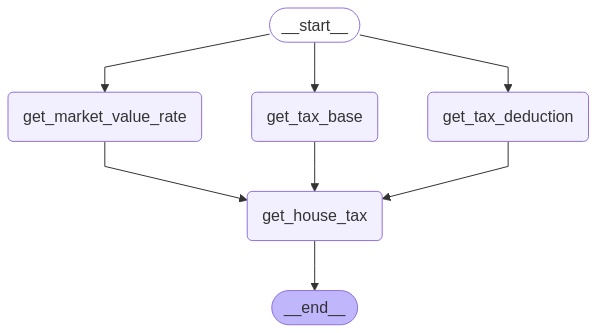

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [14]:
graph.invoke({'question': question})

{'question': '내가 10억짜리 집을 2채 가지고 있다면 세금을 얼마나 내나요?',
 'answer': '먼저, 과세표준을 계산해야 합니다.  \n두 주택의 공시가격 합산은 20억 원입니다.\n\n과세표준 = (20억 원 - 9억 원) × 60% = 11억 원 × 60% = 6.6억 원\n\n두 주택을 가지고 있으므로, 2주택 이하의 소유자에 대한 세율을 적용합니다.\n\n과세표준이 6억 원 초과 12억 원 이하인 경우의 세율은 360만 원 + (6억 원을 초과하는 금액의 1천분의 10) 입니다.\n\n6.6억 원의 과세표준에서 6억 원을 초과하는 금액은 0.6억 원입니다.\n\n세금 = 360만 원 + (0.6억 원 × 1천분의 10) = 360만 원 + 60만 원 = 420만 원\n\n따라서, 납부해야 할 종합부동산세액은 420만 원입니다.',
 'tax_base': '주택에 대한 종합부동산세 과세표준은 다음과 같이 계산됩니다:  \n과세표준 = (주택의 공시가격 합산 - 공제금액) × 공정시장가액비율.',
 'tax_deduction': '9억 원',
 'market_value_rate': '공정시장가액비율 60%'}